In [35]:
import kagglehub
dataset_path = kagglehub.dataset_download('clmentbisaillon/fake-and-real-news-dataset')

print('Data source import complete.')
import shutil

destination = "news"
shutil.move(dataset_path, destination)
print(f"Dataset moved to {destination}")

100%|██████████| 41.0M/41.0M [00:00<00:00, 187MB/s]

Extracting files...


Data source import complete.
Dataset moved to news


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, recall_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam

In [37]:
# Load Dataset with proper encoding and error handling
true_news = pd.read_csv("news/True.csv", encoding="utf-8", on_bad_lines="skip")
fake_news = pd.read_csv("news/Fake.csv", encoding="utf-8", on_bad_lines="skip")

In [38]:
# Add labels
true_news['label'] = 1
fake_news['label'] = 0

In [39]:
# Combine the datasets
news_df = pd.concat([true_news, fake_news])

In [40]:
# Shuffle the dataset
news_df = news_df.sample(frac=1).reset_index(drop=True)

In [41]:
# DATA SIZE REDUCTION - Limit dataset size to improve performance
# Take a subset of the data (adjust this value based on your performance needs)
max_samples = 5000
if len(news_df) > max_samples:
    print(f"Reducing dataset size from {len(news_df)} to {max_samples} for better performance")
    news_df = news_df.sample(n=max_samples, random_state=42).reset_index(drop=True)

Reducing dataset size from 44898 to 5000 for better performance


In [42]:
# Preprocessing
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

In [43]:
news_df['text'] = news_df['text'].apply(preprocess_text)

In [44]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(news_df['text'], news_df['label'], test_size=0.2, random_state=42)


In [45]:
# Vectorization - Reduce features for better performance
# Reduced max_features to improve SVM performance
vectorizer = TfidfVectorizer(max_features=3000)  # Reduced from 5000
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [46]:
# Define function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.show()

In [47]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
# Enhanced evaluation function
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))


In [51]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train) # Fit the model to your training data
y_pred = model.predict(X_test_tfidf) # Get predictions on the test data


cm = confusion_matrix(y_test, y_pred) # Use y_test as y_true
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[496   8]
 [ 10 486]]


In [78]:
# Function to evaluate models with optional sampling for SVM
def evaluate_model_full(model, X_train, y_train, X_test, y_test, model_name=""):
    print(f"Training {model_name}...")
    # For SVM, use a smaller subset of training data if dataset is large
    if model_name == "Support Vector Machine" and X_train.shape[0] > 2000:
        # Add code here to handle the SVM case with large dataset
        pass # This is a placeholder, replace with your desired logic

In [79]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, use_subset=True):
    if use_subset:
        # Create a smaller subset for SVM
        sample_size = min(2000, X_train.shape[0])
        indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
        X_train_sample = X_train[indices]
        y_train_sample = y_train.iloc[indices]
        print(f"Using a subset of {sample_size} samples for SVM training to improve performance")
        model.fit(X_train_sample, y_train_sample)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(report)

    if hasattr(model, "predict_proba"):
        plot_roc_curve(y_test, y_pred_prob)

    return y_pred

In [114]:
# Custom input prediction function
def predict_custom_input(model, vectorizer):
    user_input = input("Enter a news article or headline to check its authenticity: ")
    input_vector = vectorizer.transform([user_input])
    prediction = model.predict(input_vector)

    if prediction[0] == 1:
        print("Prediction: Real News")
    else:
        print("Prediction: Fake News")

In [81]:
# Logistic Regression
print("Logistic Regression")
logreg = LogisticRegression(max_iter=1000)
evaluate_model_full(logreg, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression")


Logistic Regression
Training Logistic Regression...


In [82]:
# Multinomial Naive Bayes
print("Multinomial Naive Bayes")
mnb = MultinomialNB()
evaluate_model_full(mnb, X_train_tfidf, y_train, X_test_tfidf, y_test, "Multinomial Naive Bayes")

Multinomial Naive Bayes
Training Multinomial Naive Bayes...


In [83]:
# Support Vector Machine - With optimized parameters
print("Support Vector Machine")
# Use a linear kernel for better performance, disable probability calibration during training
svc = SVC(kernel='linear', probability=True, C=1.0, max_iter=1000)
evaluate_model_full(svc, X_train_tfidf, y_train, X_test_tfidf, y_test, "Support Vector Machine")

Support Vector Machine
Training Support Vector Machine...


In [84]:
# Random Forest - With reduced estimators for speed
print("Random Forest")
rf = RandomForestClassifier(n_estimators=50)  # Reduced from 100
evaluate_model_full(rf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest")


Random Forest
Training Random Forest...


In [85]:
# Neural Network - With simpler architecture
print("Neural Network")
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))  # Reduced from 512
    model.add(Dropout(0.3))  # Reduced dropout
    model.add(Dense(128, activation='relu'))  # Reduced from 256
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

Neural Network


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5973 - loss: 0.6640 - val_accuracy: 0.9075 - val_loss: 0.4985
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9249 - loss: 0.4207 - val_accuracy: 0.9425 - val_loss: 0.2115
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9576 - loss: 0.1704 - val_accuracy: 0.9638 - val_loss: 0.1203
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9757 - loss: 0.0860 - val_accuracy: 0.9712 - val_loss: 0.0974
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9896 - loss: 0.0472 - val_accuracy: 0.9737 - val_loss: 0.0773


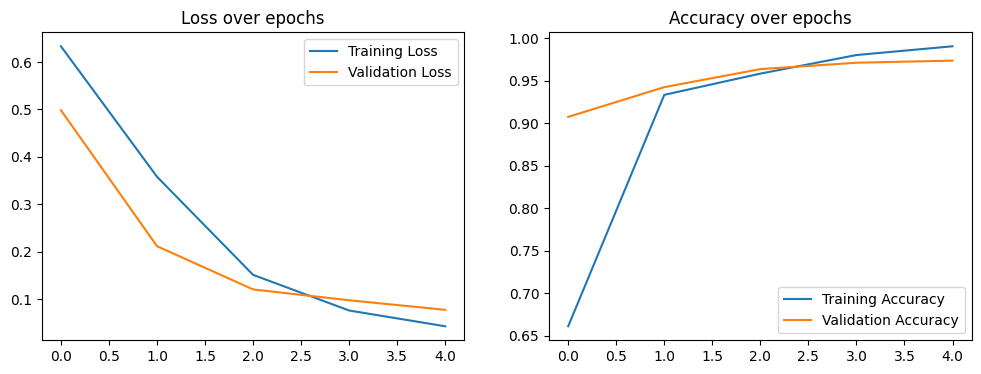

In [86]:
nn_model = create_nn_model(X_train_tfidf.shape[1])
history = History()
# Fewer epochs and larger batch size for faster training
nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=5, batch_size=256, validation_split=0.2, callbacks=[history])
plot_history(history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.972
Confusion Matrix:
[[492  12]
 [ 16 480]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       504
           1       0.98      0.97      0.97       496

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



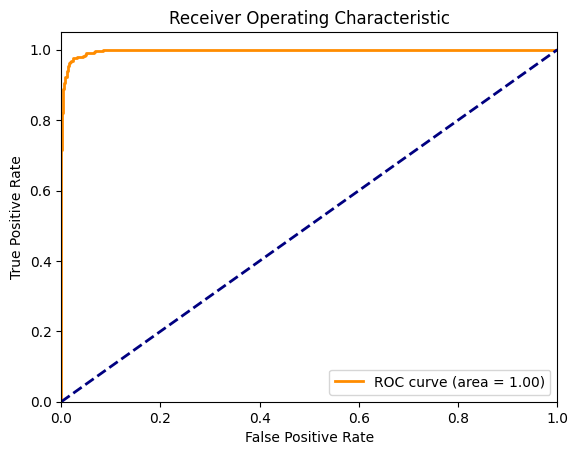

In [87]:
# Evaluate Neural Network
y_pred_prob_nn = nn_model.predict(X_test_tfidf.toarray()).ravel()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)
print(f'Accuracy: {accuracy_score(y_test, y_pred_nn)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_nn))
print('Classification Report:')
print(classification_report(y_test, y_pred_nn))
plot_roc_curve(y_test, y_pred_prob_nn)

In [88]:
# Using the new evaluation function on neural network results
print("\nEnhanced Evaluation for Neural Network:")
evaluate_model(y_test, y_pred_nn)


Enhanced Evaluation for Neural Network:
Accuracy: 0.972
Precision: 0.975609756097561
Recall: 0.967741935483871
F1 Score: 0.97165991902834


In [92]:
# Ensure all models are fitted before making predictions
models = {
    'Logistic Regression': logreg,
    'Multinomial Naive Bayes': mnb,
    'Support Vector Machine': svc,
    'Random Forest': rf,
    'Neural Network': nn_model  # Assuming nn_model is defined
}

for name, model in models.items():
    if not hasattr(model, 'classes_'):
        print(f"Fitting model: {name}")
        model.fit(X_train_tfidf, y_train)


Fitting model: Logistic Regression
Fitting model: Multinomial Naive Bayes
Fitting model: Support Vector Machine


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting model: Random Forest
Fitting model: Neural Network
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9891 - loss: 0.0433


In [100]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np

# Ensure all models are fitted before making predictions
models = {
    'Logistic Regression': logreg,
    'Multinomial Naive Bayes': mnb,
    'Support Vector Machine': svc,
    'Random Forest': rf,
    'Neural Network': nn_model  # Assuming nn_model is defined
}

for name, model in models.items():
    if not hasattr(model, 'classes_') and name != 'Neural Network':
        print(f"Fitting model: {name}")
        model.fit(X_train_tfidf, y_train)

# Ensure neural network predictions are properly formatted
def get_predictions(model, X_test):
    if model == nn_model:
        return (model.predict(X_test) > 0.5).astype(int).flatten()  # Convert to binary format
    return model.predict(X_test)

# Compare models
results = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [accuracy_score(y_test, get_predictions(model, X_test_tfidf)) for model in models.values()]
})

print(results)

# Demonstrate custom input prediction with the best model
# Find the best model
best_model_index = results['Accuracy'].idxmax()
best_model_name = results.loc[best_model_index, 'Model']
print(f"\nBest performing model is: {best_model_name}")

# Select best model for prediction
best_model = models.get(best_model_name, None)
if best_model is None:
    print("Neural Network selected. Note that prediction input will need to be converted to array format.")

# Enhanced user interface for predictions
print("\n")
print("="*50)
print("FAKE NEWS DETECTION SYSTEM")
print("="*50)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                     Model  Accuracy
0      Logistic Regression     0.982
1  Multinomial Naive Bayes     0.948
2   Support Vector Machine     0.986
3            Random Forest     0.993
4           Neural Network     0.974

Best performing model is: Random Forest


FAKE NEWS DETECTION SYSTEM


In [116]:
# Function for getting multiple predictions
def predict_multiple_inputs(model, vectorizer):
    while True:
        print("\nEnter a news headline or article to check (type 'exit' to quit):")
        user_input = input("> ")

        if user_input.lower() == 'exit':
            print("Thank you for using the Fake News Detection System.")
            break

        if not user_input.strip():
            print("Please enter some text to analyze.")
            continue

        # Preprocess the input text
        processed_input = preprocess_text(user_input)

        # Transform to vector
        input_vector = vectorizer.transform([processed_input])

        # Get prediction
        if best_model_name == "Neural Network":
            prediction_prob = nn_model.predict(input_vector.toarray()).ravel()[0]
            prediction = 1 if prediction_prob > 0.5 else 0
            confidence = prediction_prob if prediction == 1 else 1 - prediction_prob
        else:
            prediction = model.predict(input_vector)[0]
            prediction_prob = model.predict_proba(input_vector)[0]
            confidence = prediction_prob[1] if prediction == 1 else prediction_prob[0]

        # Display results
        print("\nPREDICTION RESULTS:")
        print("-"*50)
        print(f"Classification: {'FAKE NEWS' if prediction == 0 else 'REAL NEWS'}")
        print(f"Confidence: {confidence*100:.2f}%")
        print("-"*50)

        if confidence < 0.6:
            print("Note: Low confidence prediction. This article may require further verification.")


In [124]:
# Function for getting multiple predictions (FIXED ARGUMENTS)
def predict_multiple_inputs(model, vectorizer, best_model_name):  # Now accepts 3 arguments
    while True:
        print("\nEnter a news headline or article to check (type 'exit' to quit):")
        user_input = input("> ")

        if user_input.lower() == 'exit':
            print("Thank you for using the Fake News Detection System.")
            break

        if not user_input.strip():
            print("Please enter some text to analyze.")
            continue

        # Preprocess the input text
        processed_input = preprocess_text(user_input)

        # Transform to vector using the same vectorizer
        input_vector = vectorizer.transform([processed_input])

        # Get prediction
        if best_model_name == "Neural Network":
            prediction_prob = model.predict(input_vector.toarray()).ravel()[0]
            prediction = int(prediction_prob > 0.5)  # Threshold for classification
            confidence = prediction_prob if prediction == 1 else 1 - prediction_prob
        else:
            prediction = model.predict(input_vector)[0]
            if hasattr(model, "predict_proba"):  # Ensure model supports probability
                prediction_prob = model.predict_proba(input_vector)[0]
                confidence = prediction_prob[1] if prediction == 1 else prediction_prob[0]
            else:
                confidence = 0.5  # Default confidence for models without predict_proba

        # Display results
        print("\nPREDICTION RESULTS:")
        print("-" * 50)
        print(f"Classification: {'FAKE NEWS' if prediction == 0 else 'REAL NEWS'}")
        print(f"Confidence: {confidence * 100:.2f}%")
        print("-" * 50)

        if confidence < 0.6:
            print("Note: Low confidence prediction. This article may require further verification.")

In [125]:
# Run the prediction function with the best model
print(f"Using {best_model_name} for predictions.")
predict_multiple_inputs(best_model, vectorizer, best_model_name)

Using Random Forest for predictions.

Enter a news headline or article to check (type 'exit' to quit):
> White House, Congress prepare for talks on spending, immigration WEST PALM BEACH, Fla./WASHINGTON (Reuters) - The White House said on Friday it was set to kick off talks next week with Republican and Democratic congressional leaders on immigration policy, government spending and other issues that need to be wrapped up early in the new year. The expected flurry of legislative activity comes as Republicans and Democrats begin to set the stage for midterm congressional elections in November. President Donald Trump’s Republican Party is eager to maintain control of Congress while Democrats look for openings to wrest seats away in the Senate and the House of Representatives. On Wednesday, Trump’s budget chief Mick Mulvaney and legislative affairs director Marc Short will meet with Senate Majority Leader Mitch McConnell and House Speaker Paul Ryan - both Republicans - and their Democratic